## Proyecto Final Redes Neuronales

- Martínez Cano Ricardo Iván 
- Victoria Morales Ricardo Maximiliano

## Delimitación del problema

Se busca desarrollar una red neuronal que sea capaz de recibir imágenes e informarnos si encontró un vehículo en la imágen. Esta red neuronal podría utilizarse con el objetivo de monitorear el flujo vehícular o gestionar un sistema de estacionamientos. 

<br> Entrada </br>
- La red neuronal recibe imágenes presentadas por una cámara dirigida hacia una carretera o a un estacionamiento donde existe la posibilidad de encontrar algún vehículo. 

<br> Salida </br>
- La red neuronal va a regresar un tensor de 2 dimensiones que informa si la imágen contiene algún vehículo o si no hay ningun vehículo. 

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
 

In [3]:
class Config: 
    DATA_DIR = 'data'
    SPLIT_DIR = 'split'
    PLOT_DIR = 'plots'
    IMG_SIZE = (64, 64)
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 0.001
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CLASSES = ['Non-Vehicle', 'Vehicle']
    NUM_CLASSES = len(CLASSES)
    MODEL_SAVE_PATH = 'model.pth'

In [4]:
# Establecer la semilla para reproducibilidad
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)

## Conjunto de entrenamiento

El conjunto de imágenes de entrenamiento se obtuvo de un conjunto de datos de Kaggle <a href = https://www.kaggle.com/code/omariovic/viechle-binary-classification> Vehicle Detection Image Set </a>, y consiste en dos carpetas de alrededor de 17,760 imágenes de tamaño 64x64: 8792 imágenes en "Vehículos" y 8962 imágenes de  "No Vehículos" donde queremos entrenar a la red neuronal utilizando dichas imágenes y etiquetas asignadas a cada imágen según la carpeta a la que pertenecen. 

Vamos a dividir el conjunto de imágenes en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba de la siguiente forma: 
- Entrenamiento: 80% de las imágenes (14,208 imágenes) 
- Validación: 10% de las imágenes (1,776 imágenes)
- Prueba: 10% de las imágenes (1,776 imágenes)


In [5]:
# Crear directorios si no existen
os.makedirs(Config.SPLIT_DIR, exist_ok=True)
os.makedirs(Config.PLOT_DIR, exist_ok=True)

In [6]:
# Transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize(Config.IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Cargar el dataset
try: 
    dataset = datasets.ImageFolder(Config.DATA_DIR, transform=transform)
except Exception as e:
    print(f"Error cargando el dataset: {e}")
    raise
targets = np.array(label for _, label in dataset.samples)

In [8]:
# Dividir el dataset en entrenamiento y validación
targets = np.array([label for _, label in dataset.samples])
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=Config.SEED
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=targets[temp_idx],
    random_state=Config.SEED
)

In [9]:
# Guardar los índices de las divisiones
np.save(os.path.join(Config.SPLIT_DIR, 'train_idx.npy'), train_idx)
np.save(os.path.join(Config.SPLIT_DIR, 'val_idx.npy'), val_idx)
np.save(os.path.join(Config.SPLIT_DIR, 'test_idx.npy'), test_idx)

In [10]:
# Crear Dataloaders para entrenamiento, validación y prueba
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

In [11]:
# Funcion para obtener el balanceo de clases
def obtener_balance(loader): 
    counts = torch.zeros(Config.NUM_CLASSES)
    for _, labels in loader:
        for label in labels:
            counts[label.item()] += 1
    total = counts.sum().item()
    porcentajes = (counts / total * 100)
    return counts.tolist(), porcentajes.tolist(), int(total)

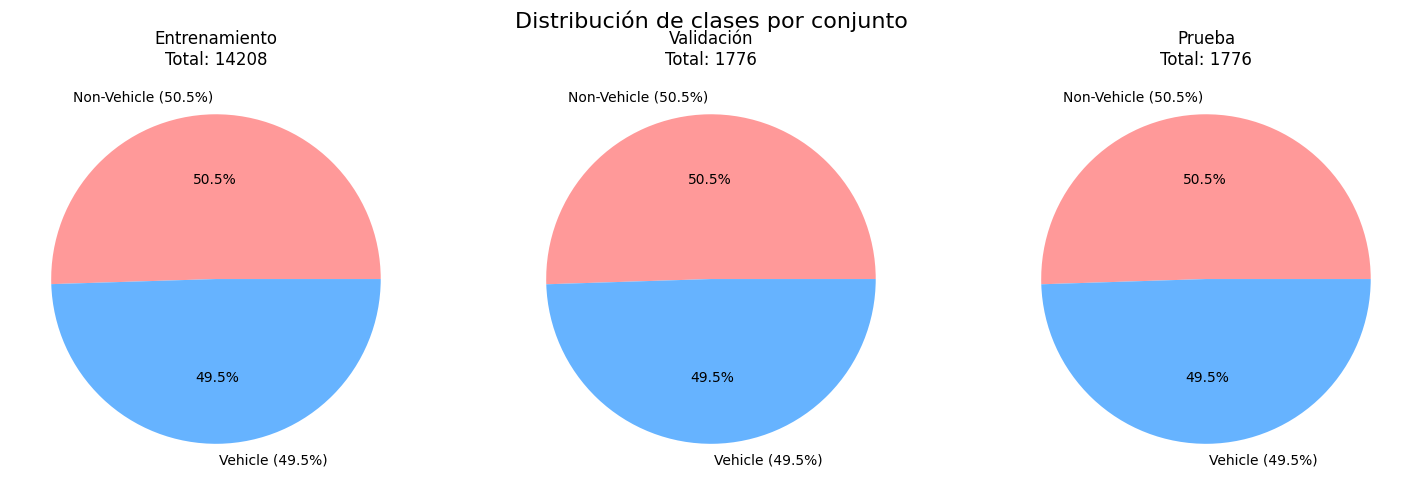

In [12]:
conjuntos = ['Entrenamiento', 'Validación', 'Prueba']
loaders = [train_loader, val_loader, test_loader]
# Graficar la distribución de clases
for loader, nombre in zip(loaders, conjuntos):
    cuentas, porcentajes, total = obtener_balance(loader)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.pie(cuentas, labels=[f"{Config.CLASSES[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
           autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    ax.set_title(f"Distribución de clases - {nombre}")
    plt.suptitle(f"Total de imágenes: {total}", fontsize=10)
    plt.savefig(f"plots/{nombre.lower()}_distribution.png")
    plt.close()

# Graficar la distribución de clases combinada
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, loader in enumerate(loaders):
    cuentas, porcentajes, total = obtener_balance(loader)
    axes[i].pie(cuentas, labels=[f"{Config.CLASSES[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
                autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    axes[i].set_title(f"{conjuntos[i]}\nTotal: {total}")

plt.suptitle("Distribución de clases por conjunto", fontsize=16)
plt.tight_layout()
plt.savefig("plots/combined_distribution.png")
plt.show()


Muestra de imágenes de vehículos:


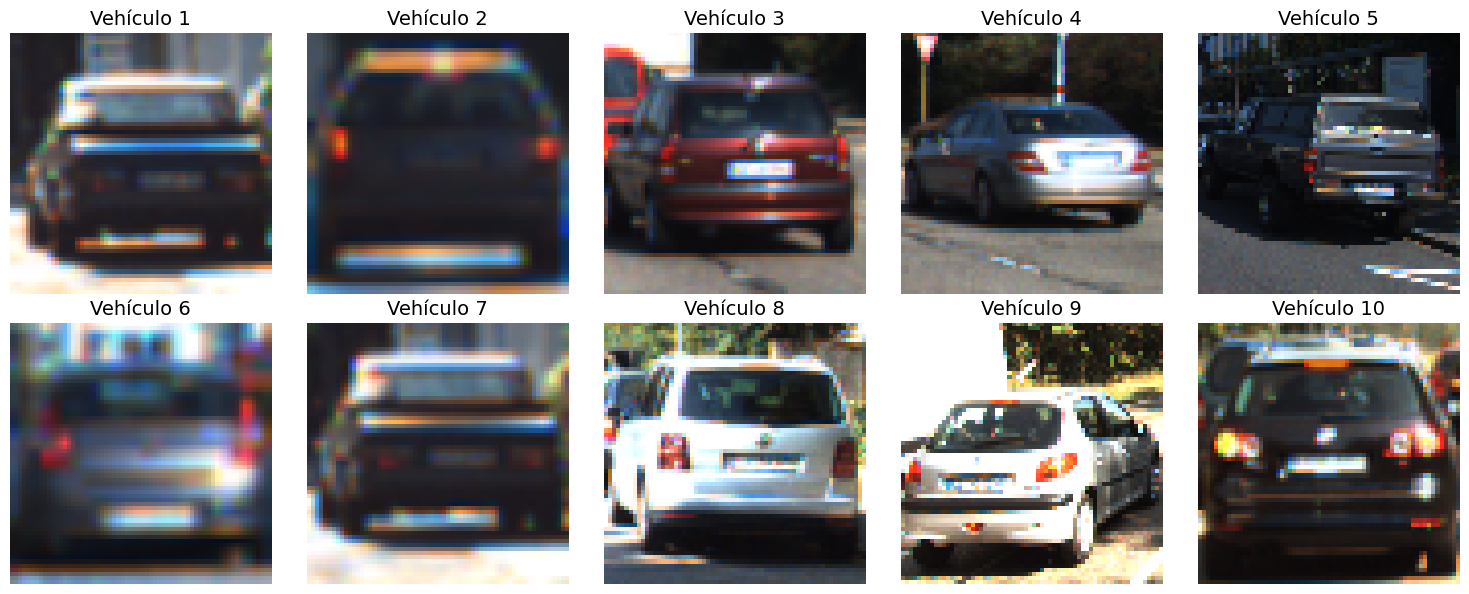


Muestras de imágenes de no vehículos:


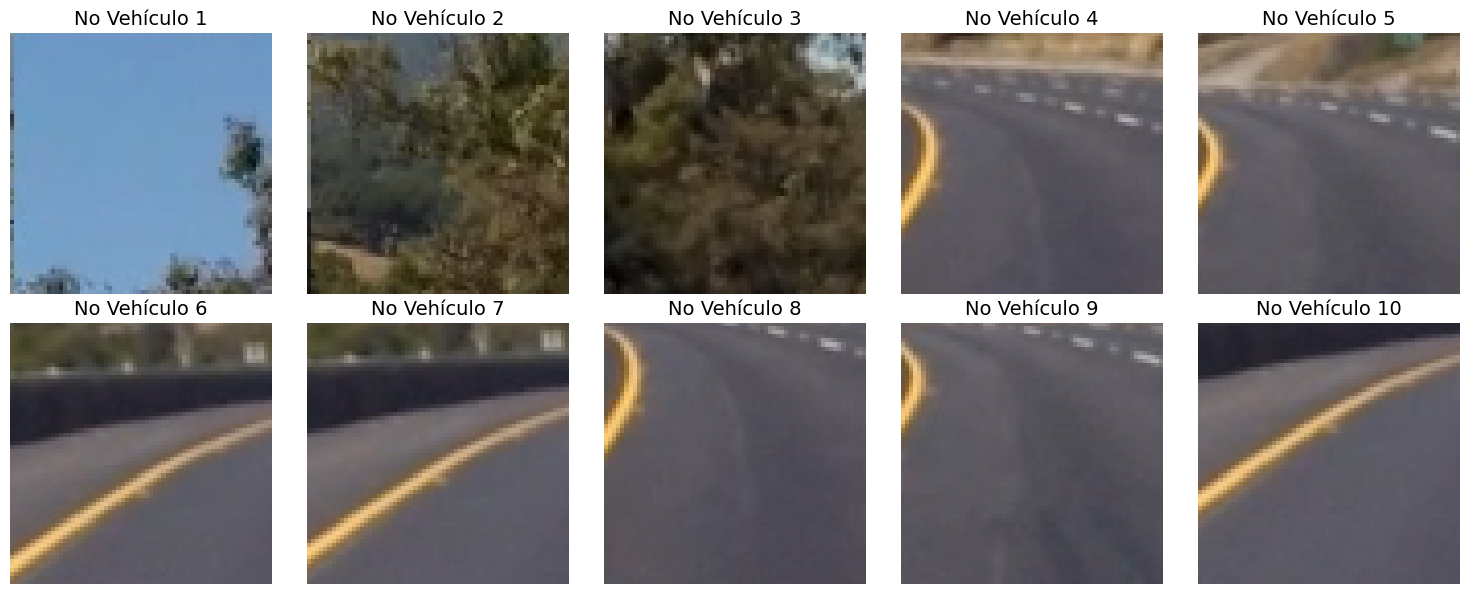

In [13]:
def load_images(directory, max_images=None, show_progress=True):
    """Carga imágenes de un directorio y las devuelve como una lista de arrays de NumPy."""
    images = []
    img_paths = glob.glob(os.path.join(directory, '*.jpg')) + glob.glob(os.path.join(directory, '*.png'))

    if not img_paths:
        print(f"No images found in directory: {directory}")
        return images

    for img_path in img_paths:
        try: 
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
                images.append(img)
                if max_images and len(images) >= max_images:
                    break
        except Exception as e:
            print(f"Error al cargar la imagen {img_path}: {e}")
    return images

# 
def display_images(images, titles=None, ncols=5, figsize=(15, 3), title_size=14):
    if not images: 
        print("No hay imágenes para mostrar")
        return 
    
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols
    fig, axes = plt.subplots(n_rows, ncols, figsize=figsize)
    
    if n_rows == 1:
        axes = [axes] if ncols == 1 else axes
    else:
        axes = axes.flatten()

    for ax in axes:
        ax.axis('off')

    for i, (ax, img) in enumerate(zip(axes[:n_images], images)):
        ax.imshow(img)
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=title_size)
        elif titles is None:
            ax.set_title(f'Image {i+1}', fontsize=title_size)
    
    plt.tight_layout()
    plt.show()

# Configuración
vehicle_dir = 'data/vehicles'
non_vehicle_dir = 'data/non-vehicles'
sample_size = 10  

# Verificar si los directorios existen
if not all(os.path.isdir(d) for d in [vehicle_dir, non_vehicle_dir]):
    print("Error: Missing required directories. Please ensure both 'data/vehicles' and 'data/non-vehicles' exist.")
    exit()

# Cargar imágenes 
vehicle_images = load_images(vehicle_dir, max_images=sample_size)
non_vehicle_images = load_images(non_vehicle_dir, max_images=sample_size)

# Mostrar imágenes con etiquetas de clases
if vehicle_images:
    print("\nMuestra de imágenes de vehículos:")
    display_images(
        vehicle_images[:sample_size],
        titles=[f"Vehículo {i+1}" for i in range(len(vehicle_images[:sample_size]))],
        figsize=(15, 3 * ((sample_size // 5)))
    )
else:
    print("No se encontraron imágenes de vehículos")

if non_vehicle_images:
    print("\nMuestras de imágenes de no vehículos:")
    display_images(
        non_vehicle_images[:sample_size],
        titles=[f"No Vehículo {i+1}" for i in range(len(non_vehicle_images[:sample_size]))],
        figsize=(15, 3 * ((sample_size // 5) ))
    )
else:
    print("No se encontraron imágenes de no vehículos")


## Arquitectura de la red

La arquitectura de la red neuronal consiste en lo siguiente: 

- Una capa convolucional de entrada con un filtro de 3x3 y 64 filtros de salida
- Una capa de normalización 2D y una función de activación ReLU 
- Una capa de MaxPooling de (2,2)
- Otra capa convolucional con un filtro de 3x3 con 128 filtros de salida
- Una capa de normalización 2D y una función de activación ReLU
- Una capa de MaxPooling de (2,2)
- Otra capa convolucional con un filtro de 3x3 con 256 filtros de salida 
- Una capa de normalización 2D y una función de activación ReLU
- Una capa de MaxPooling de (2,2)
- Una capa completamente conectada con 512 neuronas 
- Una capa de normalización 1D y una función de activación ReLU
- Un dropout del 50% y otra capa completamente conectada con una salida de 2 neuronas

In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Calculate flattened size
        self.flattened_size = 256 * (Config.IMG_SIZE[0] // 8) * (Config.IMG_SIZE[1] // 8)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x
    


Starting epoch 1/10
Epoch [1/10] Loss: 0.0847 Accuracy: 96.76%
Starting epoch 2/10
Epoch [2/10] Loss: 0.0333 Accuracy: 98.88%
Starting epoch 3/10
Epoch [3/10] Loss: 0.0219 Accuracy: 99.20%
Starting epoch 4/10
Epoch [4/10] Loss: 0.0152 Accuracy: 99.49%
Starting epoch 5/10
Epoch [5/10] Loss: 0.0153 Accuracy: 99.44%
Starting epoch 6/10
Epoch [6/10] Loss: 0.0081 Accuracy: 99.73%
Starting epoch 7/10
Epoch [7/10] Loss: 0.0095 Accuracy: 99.66%
Starting epoch 8/10
Epoch [8/10] Loss: 0.0100 Accuracy: 99.68%
Starting epoch 9/10
Epoch [9/10] Loss: 0.0081 Accuracy: 99.74%
Starting epoch 10/10
Epoch [10/10] Loss: 0.0070 Accuracy: 99.77%


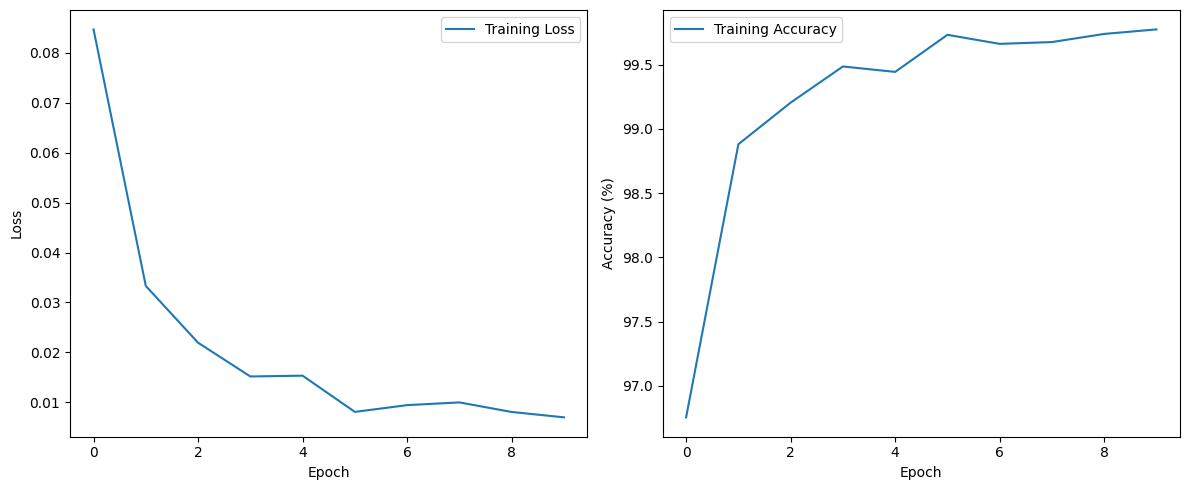

In [25]:
def train_model(model, dataloader, epochs=10, learning_rate=0.001, cuda=False):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Loss: {epoch_loss:.4f} '
              f'Accuracy: {epoch_acc:.2f}%')

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, train_accuracies
# Inicializar y entrenar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN()
cnn_model, training_losses, training_accuracies = train_model(
    cnn_model,
    train_loader,
    epochs=Config.EPOCHS,
    learning_rate=Config.LR, 
    cuda=torch.cuda.is_available()
)
 

## Entrenamiento

Para el entrenamiento se utilizaron los siguientes hiperparametros: 

- Optimizador: Adam - El optimizador Adam combina las ventajas de la función de Momentum y RMSProp para ajustar la tasa de aprendizaje durante el entrenamiento.
- Función de perdida: CrossEntropy - Se utiliza en problemas de clasificación para encontrar la diferencia entre el resultado real y el resultado obtenido por la red.
- Tasa de aprendizaje: 0.001 - Valor estandar para el optimizador Adam
- Epocas: 10 - Número de rondas observadas para obtener buenos resultados durante el entrenamiento


 Metricas de validación

 Precisión general:  99.61%

 Precisión por clase: 
Clase            Precision     Recall   F1-Score
Non-Vehicle          99.55%      99.67%      99.61%
Vehicle              99.66%      99.54%      99.60%


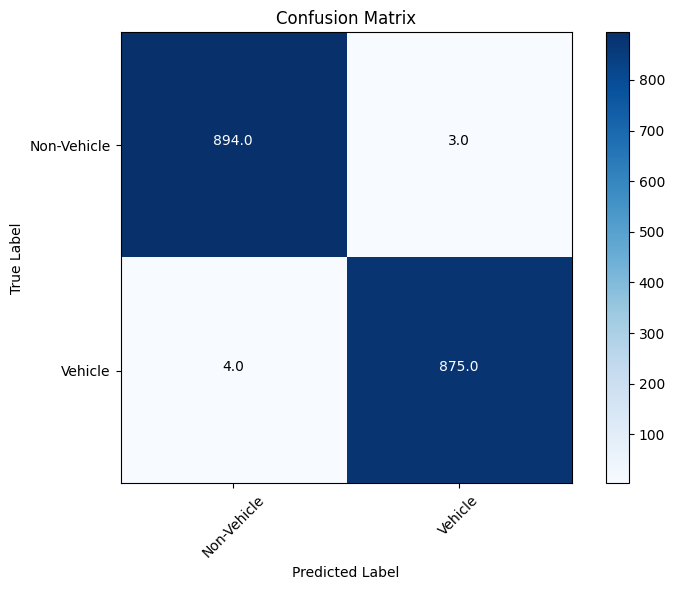


Final Validation Accuracy: 99.61%
Vehicle Recall: 99.54%


In [31]:
def validate_model(model, dataloader): 
    """Validación del modelo con multiples métricas y visualización """
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    confusion_matrix = torch.zeros(Config.NUM_CLASSES, Config.NUM_CLASSES)

    with torch.no_grad(): 
        for inputs, labels in dataloader: 
            inputs, labels = inputs.to(device), labels.to(device)

            # Evaluar las imagenes en el dataloader
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Sumar la cantidad de elementos evaluados al total
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Almacenar para el calculo de metricas
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Actualizar la matriz de confusión
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Calcular las metricas
    accuracy = 100 * correct / total
    precision = 100 * confusion_matrix.diag() / (confusion_matrix.sum(0) + 1e-6)
    recall = 100 * confusion_matrix.diag() / (confusion_matrix.sum(1) + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # Mostrar el reporte de las métricas
    print(f'\n Metricas de validación')
    print(f'{"\n Precisión general: ":<20} {accuracy:.2f}%')
    print("\n Precisión por clase: ")
    print(f'{"Clase":<15} {"Precision":>10} {"Recall":>10} {"F1-Score":>10}')
    for i, name in enumerate(Config.CLASSES):
        print(f'{name:<15} {precision[i]:>10.2f}% {recall[i]:>10.2f}% {f1[i]:>10.2f}%')

    # Gráficar matríz de confusión
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(Config.CLASSES))
    plt.xticks(tick_marks, Config.CLASSES, rotation=45)
    plt.yticks(tick_marks, Config.CLASSES)
    
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j]),
                    horizontalalignment="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix,
        'true_labels': all_labels,
        'predictions': all_preds
    }

# Ejemplo de uso
validation_metrics = validate_model(cnn_model, val_loader)
print(f"\nFinal Validation Accuracy: {validation_metrics['accuracy']:.2f}%")
print(f"Vehicle Recall: {validation_metrics['recall'][1]:.2f}%")


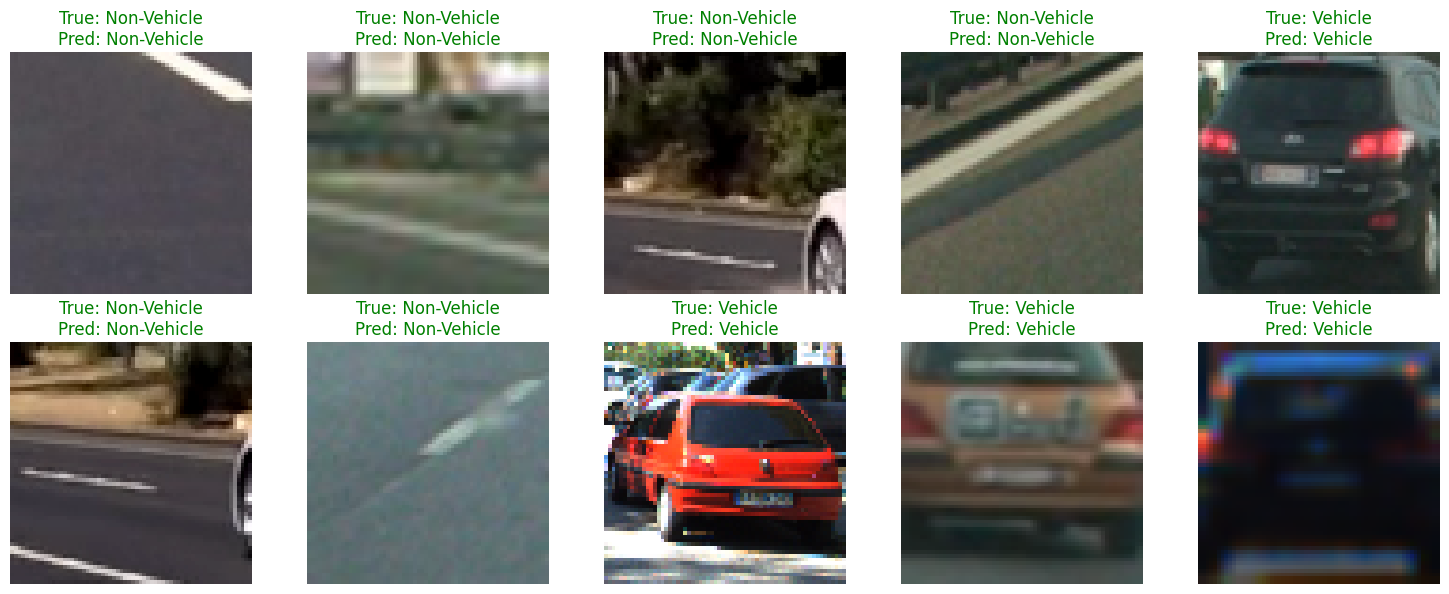

In [30]:
def test_model(model, image_tensor, transform=None):
    """Hacer una predicción para una imágen"""
    model.eval()
    with torch.no_grad():
        # 
        if transform:
            image_tensor = transform(image_tensor)
        if len(image_tensor.shape) == 3:
            image_tensor = image_tensor.unsqueeze(0)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()
    
def test_model_with_examples(model, dataloader, num_examples=10):
    """Probar el modelo con una conjunto de imágenes"""
    model.eval()
    examples = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            for i in range(len(inputs)):
                img = inputs[i]
                label = labels[i].item()
                pred = test_model(model, img)
                examples.append((img.cpu(), label, pred))
                if len(examples) >= num_examples:
                    break
            if len(examples) >= num_examples:
                break
    return examples

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Desnormalizar el tensor de una imágen normalizada"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiplicar por el std y agregar el mean
    tensor = torch.clamp(tensor, 0, 1)  
    return tensor

def show_test_examples(examples, class_names=['Non-Vehicle', 'Vehicle']):
    """Visualizar ejemplos de prueba con predicciones"""
    n = len(examples)
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
    
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for ax in axes:
        ax.axis('off')
    
    for i, (img, label, pred) in enumerate(examples):
        img = denormalize_image(img)
        img = img.permute(1, 2, 0).numpy()
        
        title_color = 'green' if label == pred else 'red'
        title = f'True: {class_names[label]}\nPred: {class_names[pred]}'
        
        axes[i].imshow(img)
        axes[i].set_title(title, color=title_color)
        axes[i].grid(False)
    
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def save_model(model, path='vehicle_classifier.pth'):
    """Guardar el modelo de la red neuronal"""
    try:
        torch.save(model.state_dict(), path)
        print(f'Model successfully saved to {path}')
        test_model = type(model)()  
        test_model.load_state_dict(torch.load(path))
        print('Model verification: Load successful')
    except Exception as e:
        print(f'Error saving model: {str(e)}')

test_examples = test_model_with_examples(cnn_model, test_loader, num_examples=10)
show_test_examples(test_examples)


In [32]:
torch.save(cnn_model.state_dict(), 'vehicle_classifier.pth')


## Bibliografía

- Dincer, B. (2021). Vehicle Detection Image Set [Conjunto de datos]. Kaggle. https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

- Bagnato, J. I. (2020). Sets de entrenamiento, test y validación cruzada. https://www.aprendemachinelearning.com/sets-de-entrenamiento-test-validacion-cruzada/

- GeeksforGeeks. (s.f.). Hyperparameter tuning. https://www.geeksforgeeks.org/hyperparameter-tuning/

